In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('drugs_side_effects_drugs_com.csv')
df.head(1)

,drug_name,medical_condition,side_effects,generic_name,drug_classes,brand_names,activity,rx_otc,pregnancy_category,csa,alcohol,related_drugs,medical_condition_description,rating,no_of_reviews,drug_link,medical_condition_url
0,doxycycline,Acne,"(hives, difficult breathing, swelling in your ...",doxycycline,"Miscellaneous antimalarials, Tetracyclines","Acticlate, Adoxa CK, Adoxa Pak, Adoxa TT, Alod...",87%,Rx,D,N,X,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,6.8,760.0,https://www.drugs.com/doxycycline.html,https://www.drugs.com/condition/acne.html


In [ ]:
columns_to_drop = ['alcohol', 'related_drugs', 'brand_names', 'drug_link', 'medical_condition_url', 'medical_condition_description']
df_cleaned = df.drop(columns=columns_to_drop)

df_cleaned = df_cleaned.dropna(subset=['side_effects'])

for col in ['generic_name', 'drug_classes', 'pregnancy_category', 'rx_otc']:
    df_cleaned[col] = df_cleaned[col].fillna('Unknown')

df_cleaned['rating'] = df_cleaned['rating'].fillna(df_cleaned['rating'].median())
df_cleaned['no_of_reviews'] = df_cleaned['no_of_reviews'].fillna(df_cleaned['no_of_reviews'].median())


In [4]:
df_cleaned.head(1)

,drug_name,medical_condition,side_effects,generic_name,drug_classes,activity,rx_otc,pregnancy_category,csa,rating,no_of_reviews
0,doxycycline,Acne,"(hives, difficult breathing, swelling in your ...",doxycycline,"Miscellaneous antimalarials, Tetracyclines",87%,Rx,D,N,6.8,760.0


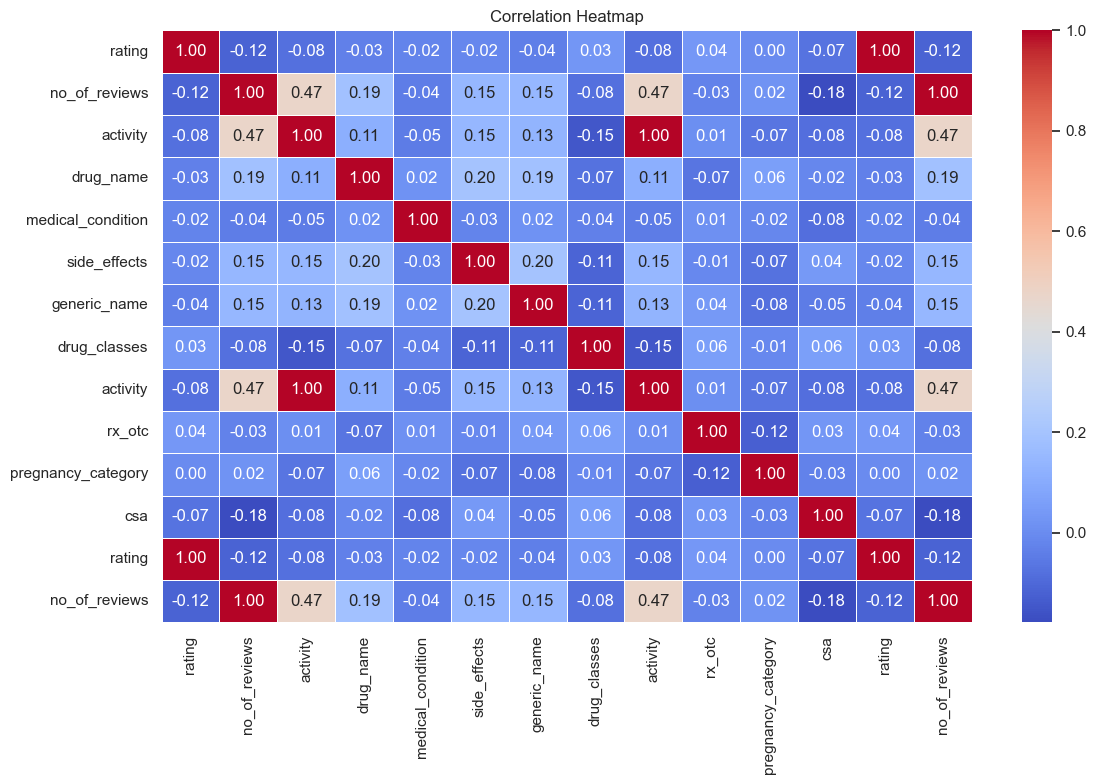

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = df_cleaned.copy()

cat_cols = ['drug_name', 'medical_condition', 'side_effects', 'generic_name', 'drug_classes', 'activity', 'rx_otc', 'pregnancy_category', 'csa','rating', 'no_of_reviews']
df_viz[cat_cols] = df_viz[cat_cols].astype('category').apply(lambda x: x.cat.codes)

df_viz['activity'] = df_cleaned['activity'].str.replace('%', '').astype(float)

numeric_df = df_viz[['rating', 'no_of_reviews', 'activity'] + cat_cols]

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


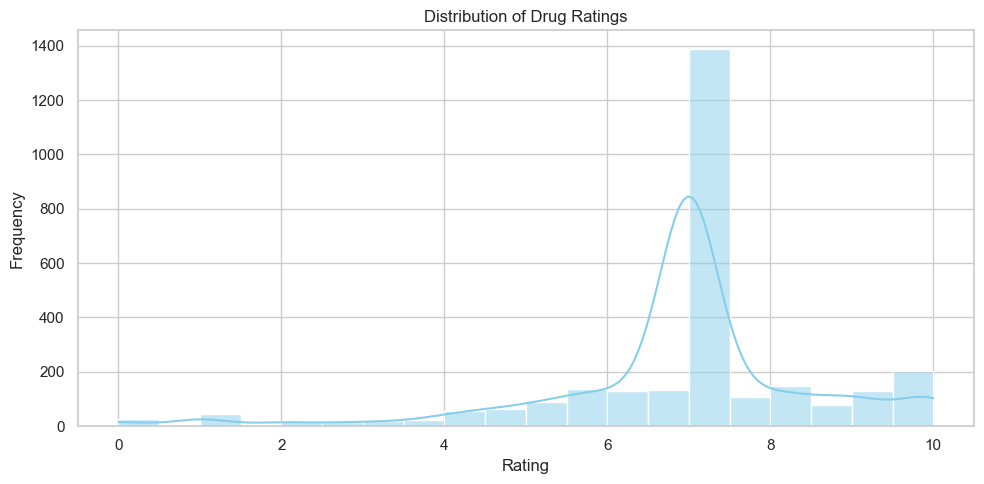

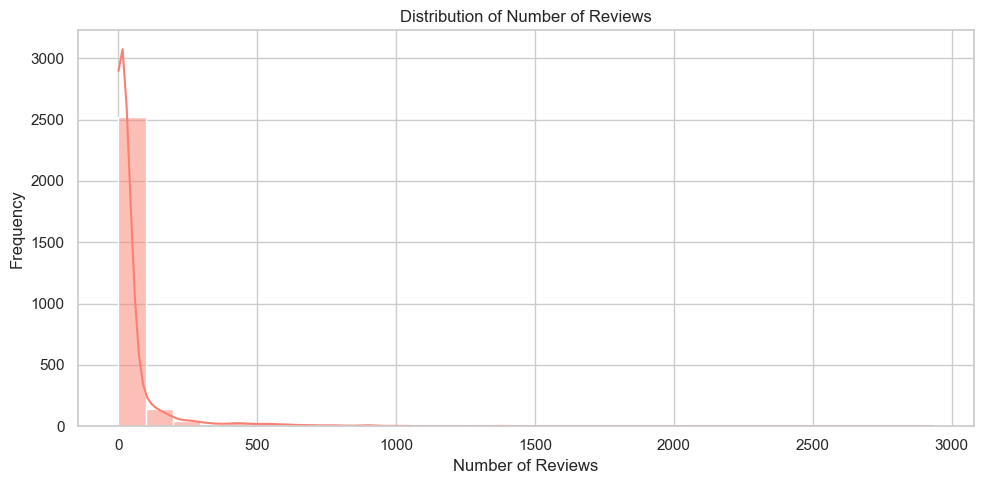

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df_cleaned['rating'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Drug Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df_cleaned['no_of_reviews'], bins=30, kde=True, color='salmon')
plt.title('Distribution of Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\subha\AppData\Local\Temp\ipykernel_16244\2621757535.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=list(labels), x=list(values), palette="viridis")


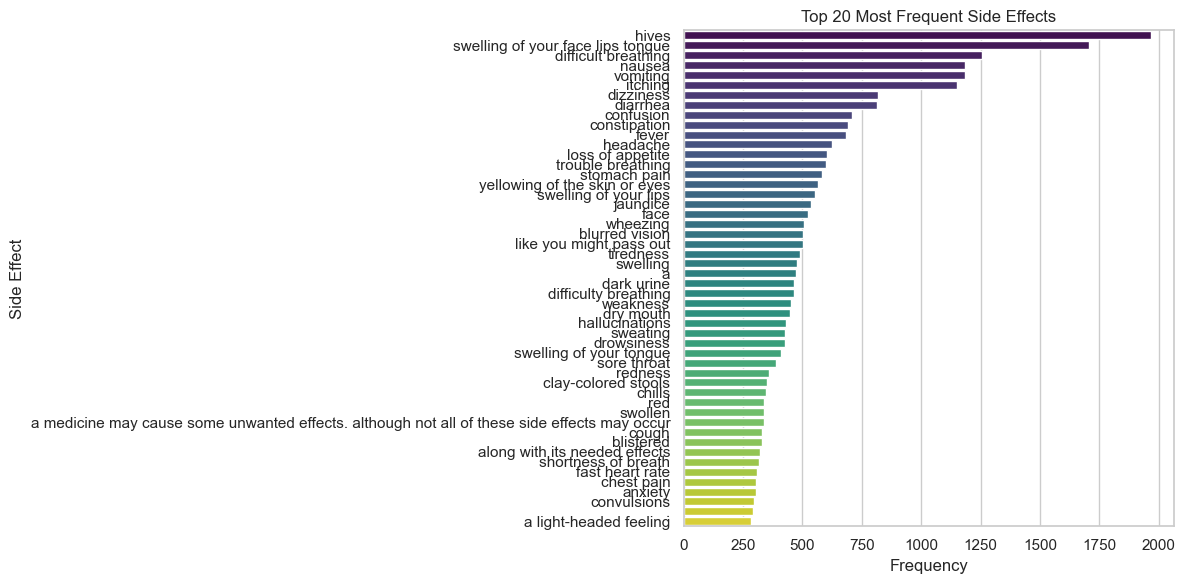

In [ ]:
from collections import Counter
import re

side_effects_flat = []
for s in df_cleaned['side_effects']:
    s_clean = re.sub(r"[;()]", ",", s)
    s_list = [x.strip().lower() for x in s_clean.split(',') if x.strip()]
    side_effects_flat.extend(s_list)

side_effect_counts = Counter(side_effects_flat)
top_50_effects = side_effect_counts.most_common(50)

labels, values = zip(*top_50_effects)
plt.figure(figsize=(12, 6))
sns.barplot(y=list(labels), x=list(values), palette="viridis")
plt.title("Top 20 Most Frequent Side Effects")
plt.xlabel("Frequency")
plt.ylabel("Side Effect")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
import re

def clean_side_effects(text):
    text = re.sub(r"[;()]", ",", text)
    return [s.strip().lower() for s in text.split(',') if s.strip()]

df_cleaned['side_effect_list'] = df_cleaned['side_effects'].apply(clean_side_effects)

side_effects_flat = [e for lst in df_cleaned['side_effect_list'] for e in lst]
top_50_effects = [e for e, _ in Counter(side_effects_flat).most_common(50)]

df_cleaned['side_effect_list'] = df_cleaned['side_effect_list'].apply(lambda lst: [e for e in lst if e in top_50_effects])

mlb_top50 = MultiLabelBinarizer(classes=top_50_effects)
side_effects_df = pd.DataFrame(mlb_top50.fit_transform(df_cleaned['side_effect_list']), columns=mlb_top50.classes_)


In [9]:
df_cleaned.head(1)

,drug_name,medical_condition,side_effects,generic_name,drug_classes,activity,rx_otc,pregnancy_category,csa,rating,no_of_reviews,side_effect_list
0,doxycycline,Acne,"(hives, difficult breathing, swelling in your ...",doxycycline,"Miscellaneous antimalarials, Tetracyclines",87%,Rx,D,N,6.8,760.0,"[hives, difficult breathing, fever, sore throa..."


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

X_raw = df_cleaned[['drug_name', 'medical_condition', 'generic_name', 'drug_classes',
                    'rx_otc', 'pregnancy_category', 'csa', 'rating', 'no_of_reviews']]
y = side_effects_df

categorical_cols = ['drug_name', 'medical_condition', 'generic_name', 'drug_classes',
                    'rx_otc', 'pregnancy_category', 'csa']
numerical_cols = ['rating', 'no_of_reviews']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)


In [11]:
X_train.data

array([ 1.,  1.,  1., ...,  1.,  7., 13.])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input

input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

model = Sequential()
model.add(Input(shape=(input_dim,)))  
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(output_dim, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_train.toarray(), y_train,
          epochs=30, batch_size=32, validation_split=0.1,
          callbacks=[early_stop])


Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.1937 - loss: 0.6420 - val_accuracy: 0.6889 - val_loss: 0.4471
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4285 - loss: 0.4589 - val_accuracy: 0.5956 - val_loss: 0.4234
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5358 - loss: 0.4218 - val_accuracy: 0.5333 - val_loss: 0.3992
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4232 - loss: 0.3788 - val_accuracy: 0.6711 - val_loss: 0.3734
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4833 - loss: 0.3433 - val_accuracy: 0.4044 - val_loss: 0.3492
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.3809 - loss: 0.2864 - val_accuracy: 0.3956 - val_loss: 0.3392
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.3168 - loss: 0.2650 - val_accuracy: 0.3867 - val_loss: 0.3209
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.2886 - loss: 0.2301 - val_accuracy: 0.3378 - v

In [ ]:
from sklearn.metrics import classification_report

y_pred_nn = model.predict(X_test.toarray()) > 0.6  # sigmoid threshold 0.3

print(classification_report(y_test, y_pred_nn, target_names=mlb_top50.classes_, zero_division=0))


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
                                                                                              precision    recall  f1-score   support

                                                                                       hives       0.87      0.91      0.89       381
                                                           swelling of your face lips tongue       0.88      0.88      0.88       335
                                                                         difficult breathing       0.91      0.64      0.75       253
                                                                                      nausea       0.85      0.47      0.60       186
                                                                                    vomiting       0.81      0.46      0.59       168
                                                                                     itching       0.89      0.72      0.79       197
                      

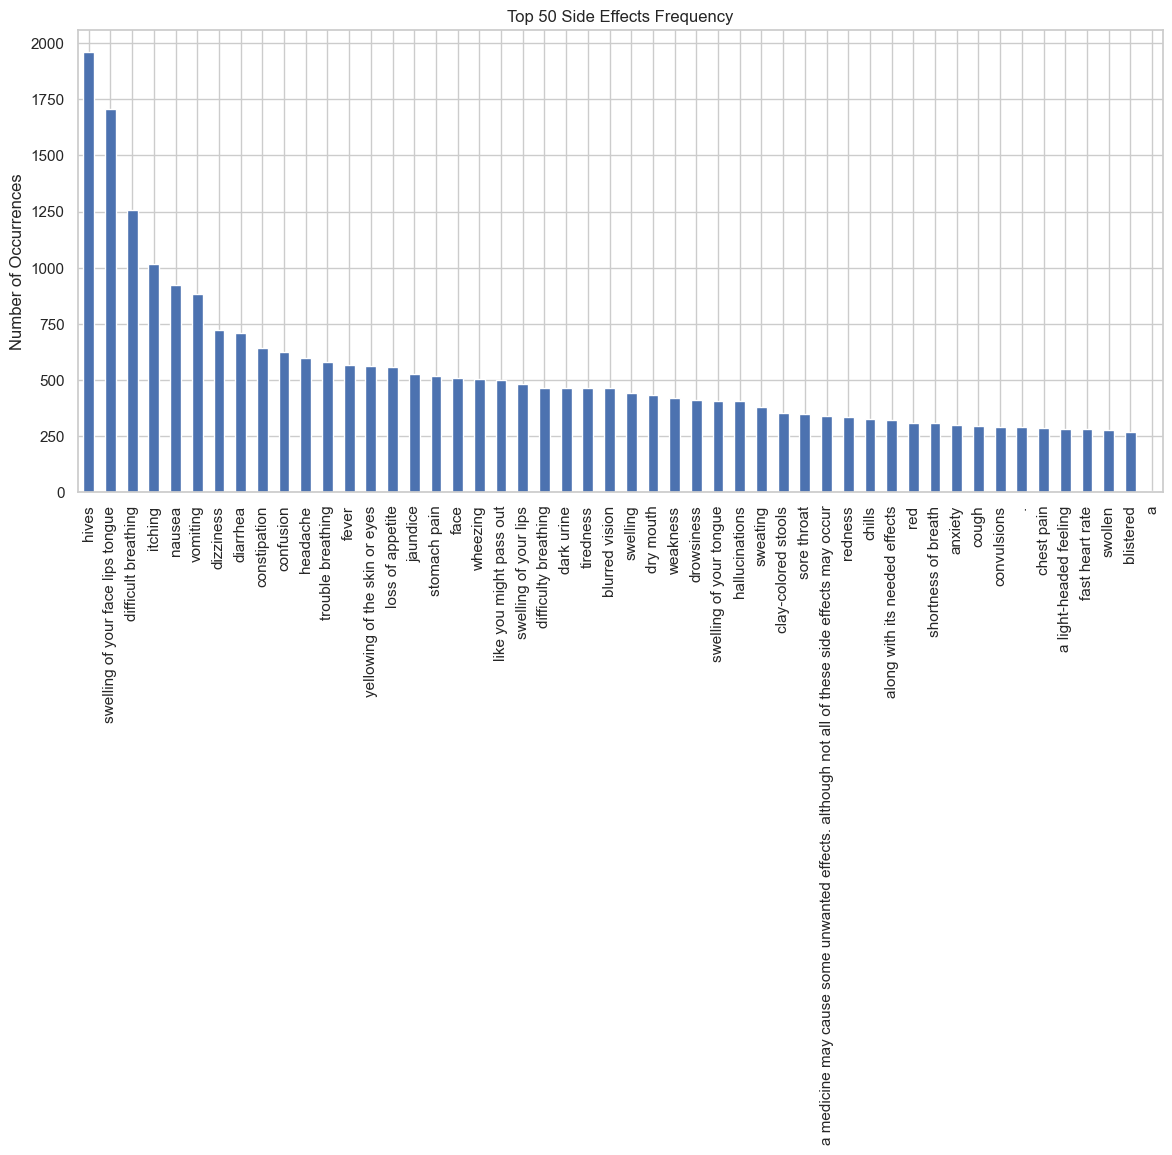

In [14]:
import matplotlib.pyplot as plt
side_effects_df.sum().sort_values(ascending=False).plot(kind='bar', figsize=(14, 6))
plt.title("Top 50 Side Effects Frequency")
plt.ylabel("Number of Occurrences")
plt.show()


In [ ]:
model.save("side_effect_predictor.keras")  # Don't use .h5 anymore

import joblib
joblib.dump(preprocessor, "preprocessor.pkl")
joblib.dump(mlb_top50, "mlb_top50.pkl")


['mlb_top50.pkl']

In [ ]:
new_input = {
    "drug_name": "doxycycline",
    "medical_condition": "Acne",
    "generic_name": "doxycycline",
    "drug_classes": "	Miscellaneous antimalarials, Tetracyclines",
    "rx_otc": "Rx",
    "pregnancy_category": "D",
    "csa": "Schedule 2",
    "rating": 6.8,
    "no_of_reviews": 760
}

new_input_df = pd.DataFrame([new_input])

X_new = preprocessor.transform(new_input_df)

y_pred_new = model.predict(X_new.toarray())[0]

y_pred_labels = (y_pred_new > 0.6)

predicted_side_effects = mlb_top50.inverse_transform(np.array([y_pred_labels]))[0]

print("Predicted Side Effects for Input:\n", predicted_side_effects)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted Side Effects for Input:
 ('hives', 'swelling of your face lips tongue', 'nausea', 'vomiting')
